## Working with Geolocated Data

Beside working with time distribution, Radarly offers several features to work with geolocated data and, so build some geographical distribution of some metrics. The available metrics for this geographical distrubution are the usual metrics: estimated reach, volume of documents (with or without retweet and repost), impressions or engagement actions (these metrics are those available in ``METRICS`` of ``radarly.constants``.

In [1]:
from datetime import datetime
from radarly import RadarlyApi
from radarly.project import Project
import pandas as pd
from matplotlib import pyplot as plt

RadarlyApi.init()

project = Project.find(pid=2989)
project

<Project.pid=2989.label=Luxury [OFFICIAL DEMO]>

In [2]:
dashboard = project.dashboards[0]
dashboard

<Dashboard.id=10389.label=1. Watch Brands>

### Localization

The ``Localization`` object is an object used to retrieve and store both statistics about the metric asked and information about the different locations returned in the distribution.

The payload sent to the API can be built with the ``LocalizationParameter`` defined in ``radarly.parameters``. It is used to specify the subset of publications  on which the distribution must be computed and to configure the format of returned data (language for the labels, granularity level of the dsitribution (region or town), ...). You can then use the ``get_localizations`` method of a project or the ``fetch`` class method of ``Localization`` defined in ``radarly.localization`` (by specifying the project's id as first argument and then the payload object).

In [3]:
from radarly.parameters import LocalizationParameter
from radarly.constants import METRIC, TONE

In [4]:
loca_param = LocalizationParameter() \
    .tones(TONE.POSITIVE, TONE.NEUTRAL) \
    .flag(retweet=False) \
    .publication_date(datetime(2018, 1, 1), datetime(2018, 4, 30)) \
    .focuses(include=dashboard.focuses) \
    .locale('en_GB') \
    .geo_type('town') \
    .timezone('Europe/Paris') \
    .metrics(METRIC.DOC, METRIC.ENGAGEMENT, METRIC.IMPRESSION)

loca = project.get_localizations(loca_param)
loca

<Localization.length=100>

The ``Localization`` has the same structure as a list where each item is a piece of information about one location (data about the metrics asked, name of the location, population of the location, coordinates...). The object can be parsed with ``pandas``.

In [5]:
loca = pd.DataFrame(loca)
loca.head()

,doc,engagement,id,id_str,impression,iso_code,lang,lat,lng,name,population
0,223,213,72057594039723206,72057594039723206,406152,,en,38.04139,114.47861,Shijiazhuang,2834942
1,156,155,72057594039726460,72057594039726460,3895123,,en,31.23513,121.52759,Pudong,0
2,1753,8427,72057594039723501,72057594039723501,56446019,,en,22.54554,114.06830,Shenzhen,10358381
3,755,535537,72057594040585832,72057594040585832,24099211,,en,47.36667,8.55000,Zürich,341730
4,87,371,72057594039733889,72057594039733889,1386855,,en,30.75220,120.75000,Jiaxing,466101


### Geogrid

A second fature has been developped in Radarly in order to offer you a better interactivity with geolocated data. It allows you for example to get some statistics only in a specific region by given the coordinates of the poylgon in which the publication must be published. ``radarly-py`` implements this feature in the object ``GeoGrid``, defined in ``radarly.geogrid``. As most of statistics objects, the payload can be built with a specific object: ``GeoParameter`` of ``radarly.parameters`` (this object is used to restrict the set of publications and specify the region in which you want some statistics).

In [6]:
from radarly.parameters import GeoParameter
from radarly.constants import METRIC
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

The ``GeoParameter`` object implements the usual methods in order to restrict the set of publications and also the ``metrics`` method to specify the metric you want and the ``geofilter`` method used to specify the geographical polygon. This object must be a list of dictionary where each dictionary has two keys: ``lon`` and ``lat`` which are the coordinates of the point of the polygon. By default, it will set a frame on the whole world.

The ``GeoGrid`` returned can be parsed with ``pandas``.

In [7]:
polygon = [ # this value is the default value of ``polygon``
    {"lon": -180, "lat": 81.01649},
    {"lon": 180, "lat": 81.01649},
    {"lon": 180, "lat": -58.94237},
    {"lon": -180, "lat": -58.94237},
    {"lon": -180, "lat": 81.01649}
]
geo_param = GeoParameter() \
    .focuses(include=dashboard.focuses) \
    .fctx(*dashboard.focuses) \
    .flag(retweet=False) \
    .publication_date(datetime(2018, 1, 1), datetime(2018, 2, 1)) \
    .metrics(METRIC.DOC, METRIC.ENGAGEMENT) \
    .geofilter(polygon)

geogrid = project.get_geogrid(geo_param)
geogrid = pd.DataFrame(geogrid)
geogrid.head()

,doc,engagement,geohash,lat,lon
0,3213,1006588,djn,29.16195,-81.07868
1,2066,502476,gcp,51.49059,-0.17139
2,1661,719854,dr5,40.71165,-73.99645
3,1219,542801,u0h,46.19020,6.15997
4,1128,221098,9q5,34.06288,-118.32346


Let's do some basic plotting of the data returned. We will use ``Basemap`` which can be easily install with ``conda``.

In [8]:
lons = geogrid.lon.apply(float).tolist()
lats = geogrid.lat.apply(float).tolist()
docs = geogrid.doc.apply(np.log10).tolist()
engagements = geogrid.engagement.apply(np.log10).tolist()

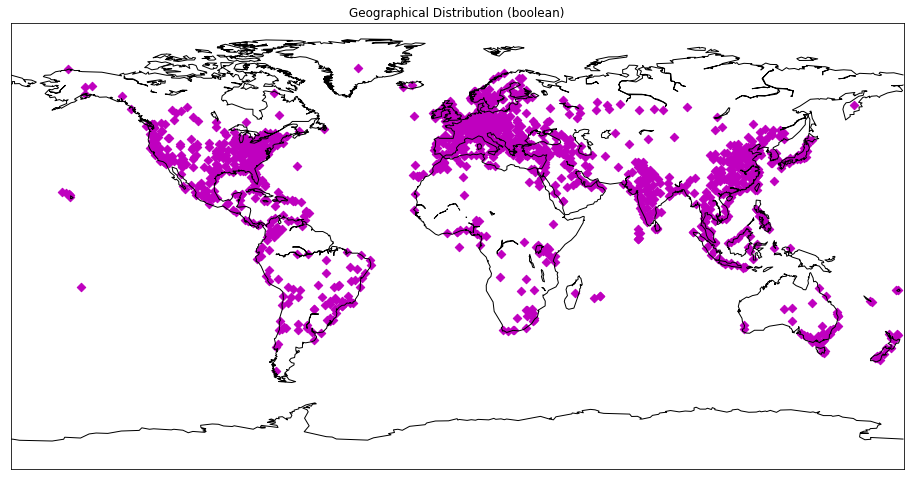

In [9]:
plt.figure(figsize=(16, 12))
m = Basemap()
m.drawcoastlines()
m.scatter(lons, lats, latlon=True, marker='D',color='m')
plt.title('Geographical Distribution (boolean)')
plt.show()

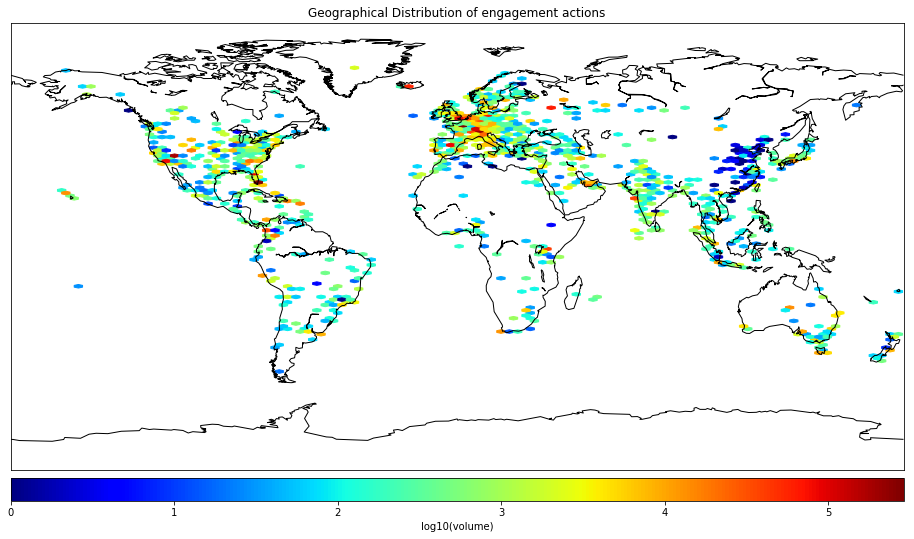

In [10]:
plt.figure(figsize=(16, 12))
m = Basemap()
m.drawcoastlines()
m.hexbin(np.array(lons), np.array(lats), C=engagements, mincnt=0, gridsize=100, cmap='jet')
cbar = m.colorbar(location='bottom')
cbar.set_label('log10(volume)')
plt.title('Geographical Distribution of engagement actions')
plt.show()

The ``geofilter`` method can be used in other objects of ``radarly.parameters``, as in ``DistributionParameter`` or in ``SearchPublicationParameter``, to specify the region you want.